# 03. Entrenar el Detector de Placas

In [1]:
import pandas as pd
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:

CSV_PATH = '../data/processed/train_detection.csv'
MODEL_PATH = '../models/detector_cnn.h5'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

In [3]:

if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    print(f'Loaded {len(df)} samples.')
else:
    print('CSV not found. Please run Notebook 01 first.')
    df = pd.DataFrame()

Loaded 828 samples.


In [4]:
def data_generator(df, batch_size=32, target_size=(224, 224), is_training=True):
    while True:
        if is_training:
            df = df.sample(frac=1).reset_index(drop=True)
            
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            images = []
            coords = []
            
            for _, row in batch_df.iterrows():
                img_path = row['image_path']
                if not os.path.exists(img_path):
                    continue
                    
                img = cv2.imread(img_path)
                if img is None: continue
                
                h_orig, w_orig = img.shape[:2]
                img_resized = cv2.resize(img, target_size)
                images.append(img_resized / 255.0)
                
                x = row['x'] / w_orig
                y = row['y'] / h_orig
                w = row['w'] / w_orig
                h = row['h'] / h_orig
                coords.append([x, y, w, h])
                
            if len(images) == 0:
                continue
                
            yield np.array(images), np.array(coords)

In [5]:

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
print(f'Train: {len(train_df)}, Val: {len(val_df)}')

Train: 745, Val: 83


In [6]:

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\Paco\miniconda3\envs\AI\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:

if not df.empty:
    history = model.fit(
        data_generator(train_df, BATCH_SIZE, IMG_SIZE),
        steps_per_epoch=len(train_df) // BATCH_SIZE,
        validation_data=data_generator(val_df, BATCH_SIZE, IMG_SIZE),
        validation_steps=len(val_df) // BATCH_SIZE,
        epochs=EPOCHS
    )
    
    os.makedirs('../models', exist_ok=True)
    model.save(MODEL_PATH)
    print(f'Model saved to {MODEL_PATH}')
else:
    print('No data to train.')

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 644ms/step - loss: 0.0539 - val_loss: 0.0199
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 591ms/step - loss: 0.0211 - val_loss: 0.0140
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 554ms/step - loss: 0.0168 - val_loss: 0.0117
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 573ms/step - loss: 0.0125 - val_loss: 0.0106
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 572ms/step - loss: 0.0114 - val_loss: 0.0098
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 575ms/step - loss: 0.0096 - val_loss: 0.0079
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 564ms/step - loss: 0.0083 - val_loss: 0.0073
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 549ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 557ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 564ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 562ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14

Model saved to ../models/detector_cnn.h5


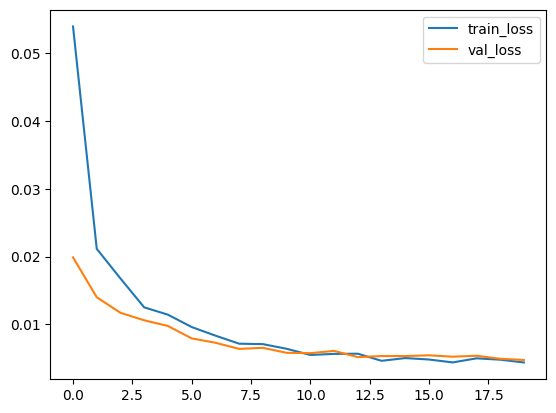

In [8]:

if 'history' in locals():
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()